<a href="https://colab.research.google.com/github/NerminHussein/HR-Analytics_Classifier/blob/main/HR_Analytics_Decision_tree_V3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HR Analytics**








# **Problem Statement**

A random large company, employs at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons -

The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
A sizeable department has to be maintained, for the purposes of recruiting new talent
More often than not, the new employees have to be trained for the job and/or given time to acclimatise themselves to the company
Hence, the management has contracted an HR analytics firm to understand what factors they should focus on, in order to curb attrition. In other words, they want to know what changes they should make to their workplace, in order to get most of their employees to stay. Also, they want to know which of these variables is most important and needs to be addressed right away.

Since you are one of the star analysts at the firm, this project has been given to you.

Goal of the case study
You are required to model the probability of attrition using a logistic regression. The results thus obtained will be used by the management to understand what changes they should make to their workplace, in order to get most of their employees to stay.




In [154]:
# Getting the model ready by importing the libraries that will be used
import pandas as pd                          # Dealing with Dataframes
import numpy as np                           # Dealing with Numpy Arrays
import glob
import os
from datetime import datetime,timedelta
import matplotlib.pyplot as plt             # matplotlib is used for ploting graphs
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import time
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import pickle

# Time Analysis

In [155]:
log_in=pd.read_csv('in_time.csv')
log_out=pd.read_csv('out_time.csv')
# Finding the columns where it contains only null values which indicates it being a day off for the company 
#Doing that for the log in Dataframe
for columnName,columnValue in log_in.iteritems():
  nu=columnValue.isnull().sum()
  if nu==len(log_in):
    log_in.drop([columnName],axis=1,inplace=True)
#Doing the same for logout Dataframe
for columnName,columnValue in log_out.iteritems():
  nu=columnValue.isnull().sum()
  if nu==len(log_out):
    log_out.drop([columnName],axis=1,inplace=True)
#Making sure the remaining null values are equal in both Dataframes
#This could indicate day off for the employees
nu_in=sum(log_in.isnull().sum())
nu_out=sum(log_out.isnull().sum())
print(nu_in==nu_out)

True


In [156]:
#Filling the null values with 0 to compre them later
log_in.replace(np.nan, 0)
log_out.replace(np.nan, 0)
#Comparing values from same column and index and if they match it will be replaced with null values
comp_df=log_in.compare(log_out,keep_shape=True)
#
nu_comp=(sum(comp_df.isnull().sum())/2)-len(log_in)
print(nu_comp==nu_in)


True


In [157]:
#Defining some parameters
work_hours_list=[]
day_off_lis=[]
g=1
#Iterating through each row in both dataframes at the same time
for (idx,s1),(_,s2) in zip(log_in.iterrows(),log_out.iterrows()):
  lis=[]
  x=0
#Iterating through each value in that row
  for (id,v1),(_,v2) in zip(s1.iteritems(),s2.iteritems()):
#Dividing the time format into date and time and calculating time difference to assess hours worked
    a=str(v1).split()
    b=str(v2).split()
    if len(a)==2:
      c=datetime.strptime(a[1],'%H:%M:%S')
      d=datetime.strptime(b[1],'%H:%M:%S')
      tmdf=d-c
      tmdh=timedelta.total_seconds(tmdf)/3600
      lis.append(float(tmdh))
    else:
      x+=1
#Creating two lists one holding average hours worked pe year for each employee and the other holding number of days off
  mea=sum(lis)/len(lis)
  work_hours_list.append(mea)
  day_off_lis.append(x-1)
  g+=1
#Getting a new Dataframe from the Dictionary
dic={'Average hours worked':work_hours_list,'Days off':day_off_lis}
work_hours=pd.DataFrame(dic)



In [158]:
#Adding an employee ID column to merge this data with the other dataframes
work_hours['EmployeeID']=work_hours.index+1
emp=work_hours.pop('EmployeeID')
work_hours.insert(0,'EmployeeID',emp)


In [159]:
work_hours.head()

,EmployeeID,Average hours worked,Days off
0,1,7.373651,17
1,2,7.718969,13
2,3,7.013240,7
3,4,7.193678,14
4,5,8.006175,4


# Pre-processing

In [160]:
employee_survey_data=pd.read_csv('employee_survey_data.csv')
print(employee_survey_data.isnull().sum())


EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64


In [161]:
# Summary of Data
print(employee_survey_data.describe())

        EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.250000                 2.000000         2.000000         2.000000
50%    2205.500000                 3.000000         3.000000         3.000000
75%    3307.750000                 4.000000         4.000000         3.000000
max    4410.000000                 4.000000         4.000000         4.000000


In [162]:
print("Mean-----------------------------------------")
print(employee_survey_data.mean())
#mean       
#EnvironmentSatisfaction       2.723603 
#JobSatisfaction               2.728246
#WorkLifeBalance               2.761436
print("Median-----------------------------------------")
print(employee_survey_data.median())
# Median
#EnvironmentSatisfaction       3.0
#JobSatisfaction               3.0
#WorkLifeBalance               3.0

# Mean & Median Approximatery same so we choose Median to Fill the NAN Data

Mean-----------------------------------------
EmployeeID                 2205.500000
EnvironmentSatisfaction       2.723603
JobSatisfaction               2.728246
WorkLifeBalance               2.761436
dtype: float64
Median-----------------------------------------
EmployeeID                 2205.5
EnvironmentSatisfaction       3.0
JobSatisfaction               3.0
WorkLifeBalance               3.0
dtype: float64


In [163]:
#Fill Null in column of EnvironmentSatisfaction with Median
employee_survey_data['EnvironmentSatisfaction'] = employee_survey_data['EnvironmentSatisfaction'].fillna(employee_survey_data['EnvironmentSatisfaction'].median())

In [164]:
#Fill Null in column of JobSatisfaction with Median
employee_survey_data['JobSatisfaction'] = employee_survey_data['JobSatisfaction'].fillna(employee_survey_data['JobSatisfaction'].median())

In [165]:
#Fill Null in column of WorkLifeBalance with Median
employee_survey_data['WorkLifeBalance'] = employee_survey_data['WorkLifeBalance'].fillna(employee_survey_data['WorkLifeBalance'].median())

In [166]:
#check if found NULL Values in employee_survey_data file 
print(employee_survey_data.isnull().sum())

EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64


In [167]:
Manager_survey_data=pd.read_csv('manager_survey_data.csv')
print(Manager_survey_data.isnull().sum())

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64


In [168]:
General_Data=pd.read_csv('general_data.csv')
print(General_Data.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


In [169]:
print("Mean-----------------------------------------")
print(General_Data.mean())
#################################################
print("Median-----------------------------------------")
print(General_Data.median())

Mean-----------------------------------------
Age                           36.923810
DistanceFromHome               9.192517
Education                      2.912925
EmployeeCount                  1.000000
EmployeeID                  2205.500000
JobLevel                       2.063946
MonthlyIncome              65029.312925
NumCompaniesWorked             2.694830
PercentSalaryHike             15.209524
StandardHours                  8.000000
StockOptionLevel               0.793878
TotalWorkingYears             11.279936
TrainingTimesLastYear          2.799320
YearsAtCompany                 7.008163
YearsSinceLastPromotion        2.187755
YearsWithCurrManager           4.123129
dtype: float64
Median-----------------------------------------
Age                           36.0
DistanceFromHome               7.0
Education                      3.0
EmployeeCount                  1.0
EmployeeID                  2205.5
JobLevel                       2.0
MonthlyIncome              49190.0
NumCom

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [170]:
General_Data['NumCompaniesWorked'] = General_Data['NumCompaniesWorked'].fillna(General_Data['NumCompaniesWorked'].mean())

In [171]:
General_Data['TotalWorkingYears'] = General_Data['TotalWorkingYears'].fillna(General_Data['TotalWorkingYears'].mean())

In [172]:
print(General_Data.isnull().sum())

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


In [173]:
Merge_Employee_Manager=employee_survey_data.merge(Manager_survey_data, on='EmployeeID')

In [174]:
Merge_Employee_Manager.head()


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,3.0,4.0,2.0,3,3
1,2,3.0,2.0,4.0,2,4
2,3,2.0,2.0,1.0,3,3
3,4,4.0,4.0,3.0,2,3
4,5,4.0,1.0,3.0,3,3


In [175]:
print(Merge_Employee_Manager.isnull().sum())

EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64


In [176]:
Merge_EM_Data=Merge_Employee_Manager.merge(General_Data, on='EmployeeID')

In [177]:
Merge_EM_Data.head(5)


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1,3.0,4.0,2.0,3,3,51,No,Travel_Rarely,Sales,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,2,3.0,2.0,4.0,2,4,31,Yes,Travel_Frequently,Research & Development,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,3,2.0,2.0,1.0,3,3,32,No,Travel_Frequently,Research & Development,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,4,4.0,4.0,3.0,2,3,38,No,Non-Travel,Research & Development,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,5,4.0,1.0,3.0,3,3,32,No,Travel_Rarely,Research & Development,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [178]:
print(Merge_EM_Data.isnull().sum())

EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


In [179]:

print("Work_Hours",work_hours.shape)
print("All_Data",Merge_EM_Data.shape)

Work_Hours (4410, 3)
All_Data (4410, 29)


In [180]:
Merge_WH_ALLData=Merge_EM_Data.merge(work_hours, on='EmployeeID')
Merge_WH_ALLData.shape

(4410, 31)

In [181]:
Merge_WH_ALLData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4410 non-null   float64
 2   JobSatisfaction          4410 non-null   float64
 3   WorkLifeBalance          4410 non-null   float64
 4   JobInvolvement           4410 non-null   int64  
 5   PerformanceRating        4410 non-null   int64  
 6   Age                      4410 non-null   int64  
 7   Attrition                4410 non-null   object 
 8   BusinessTravel           4410 non-null   object 
 9   Department               4410 non-null   object 
 10  DistanceFromHome         4410 non-null   int64  
 11  Education                4410 non-null   int64  
 12  EducationField           4410 non-null   object 
 13  EmployeeCount            4410 non-null   int64  
 14  Gender                  

In [182]:
Merge_WH_ALLDataColumns_OBJ = Merge_WH_ALLData.select_dtypes(include = ['object']).columns
Merge_WH_ALLDataColumns_OBJ

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')

In [183]:
#Making sure that the Over18 column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['Over18']:
  if i=='Y':
    cnt+=1
print(cnt)
#Making sure that the StandardHours column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['StandardHours']:
  if i==8:
    cnt+=1
print(cnt)
#Making sure that the EmployeeCount column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['EmployeeCount']:
  if i==1:
    cnt+=1
print(cnt)


# Dropping those three columns as they add no value to the data
Merge_WH_ALLData.drop(['Over18','EmployeeCount','StandardHours'],axis=1,inplace=True)

Merge_WH_ALLData.shape

4410
4410
4410


(4410, 28)

In [184]:
Merge_WH_ALLData["Attrition"] .unique()


array(['No', 'Yes'], dtype=object)

In [185]:
# Encode Gender and Attrition with 2 values where i set it with 0 & 1 
Merge_WH_ALLData["Gender"] = np.where(Merge_WH_ALLData["Gender"].str.contains("Female"), 1, 0)
Merge_WH_ALLData["Attrition"] = np.where(Merge_WH_ALLData["Attrition"].str.contains("Yes"), 1, 0)


In [186]:
# #Turing all categrical columns into categorical but with numbers to be able to model it
# need_encode=['BusinessTravel', 'Department', 'EducationField',
#        'JobRole', 'MaritalStatus']
# encoding_dict={}
# for item in need_encode:
#   unique_value=(Merge_WH_ALLData[item].unique())
#   x=0
#   unique_dict={}
#   for i in unique_value:
#     Merge_WH_ALLData[item].replace(i,x,inplace=True)
#     unique_dict[x]=i
#     x+=1
# #Creating a dictionary of dictionaries that helps the user find what each number in each of those 5 columns means
#   encoding_dict[item]=unique_dict


# print(encoding_dict)

In [187]:
#plt.figure(figsize = (20,5))
#sns.countplot(x = 'NumCompaniesWorked', data = Merge_WH_ALLData)

In [188]:
#plt.figure(figsize = (500,50))
#sns.displot(x = 'Department', data = Merge_WH_ALLData)

In [189]:
#sns.countplot(x = 'BusinessTravel', data = Merge_WH_ALLData, palette = 'Set2')

In [190]:
#sns.heatmap(Merge_EM_Data.corr(), annot=True)

In [191]:
Merge_WH_ALLData.drop(['EmployeeID'],axis=1,inplace=True)

In [192]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['BusinessTravel', 'Department', 'EducationField',
       'JobRole', 'MaritalStatus']),
    remainder='passthrough')

transformed = transformer.fit_transform(Merge_WH_ALLData)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
print(transformed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 46 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   onehotencoder__x0_Non-Travel                 4410 non-null   float64
 1   onehotencoder__x0_Travel_Frequently          4410 non-null   float64
 2   onehotencoder__x0_Travel_Rarely              4410 non-null   float64
 3   onehotencoder__x1_Human Resources            4410 non-null   float64
 4   onehotencoder__x1_Research & Development     4410 non-null   float64
 5   onehotencoder__x1_Sales                      4410 non-null   float64
 6   onehotencoder__x2_Human Resources            4410 non-null   float64
 7   onehotencoder__x2_Life Sciences              4410 non-null   float64
 8   onehotencoder__x2_Marketing                  4410 non-null   float64
 9   onehotencoder__x2_Medical                    4410 non-null   float64
 10  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Logistic Regression

In [193]:
# Data=Merge_WH_ALLData
# columnName=[]
# for col,v in Data.iteritems():
#   columnName.append(col)
# columnName.remove('Attrition')
# x = Data.loc[:, columnName]
# y = Data.loc[:, ['Attrition']]
# X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
# model = LogisticRegression(solver='liblinear', random_state=0)
# model.fit(X_train, y_train)
# sco_new=model.score(X_test, y_test)
# len(columnName)

In [194]:
# sco_old=0
# m=[]
# r=26
# while sco_new>=sco_old:
#   sco_old=sco_new
#   sco_new=0
#   for s in itertools.combinations(columnName,r):
#     x = Data.loc[:, s]
#     y = Data.loc[:, ['Attrition']]
#     X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
#     model = LogisticRegression(solver='liblinear', random_state=0)
#     model.fit(X_train, y_train)
#     a=model.score(X_test, y_test)
#     if a>sco_new:
#       sco_new=a
#       lis=s
#   for i in columnName:
#     if i in lis:
#       l=1
#     else:
#       columnName.remove(i)
#       m.append(i)
#   r+=-1
# print(m)

In [195]:

# print(m)
# print(len(columnName))

In [196]:
# for i in columnName:
#   if i in lis:
#     l=1
#   else:
#     print(i)

# Decision Tree Model

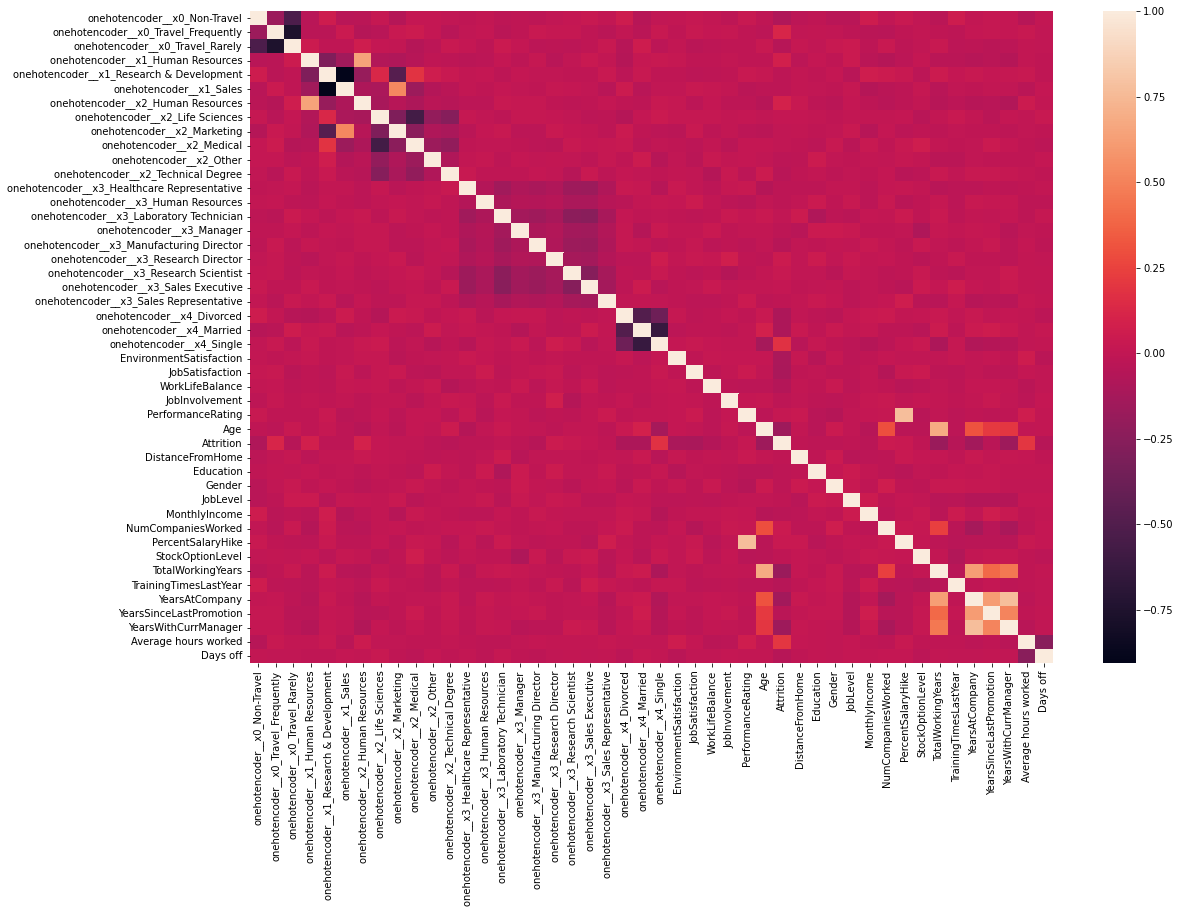

In [197]:
Data=transformed_df
Data.corr()
plt.figure(figsize = (18,12))
sns.heatmap(Data.corr())


In [198]:
Data=Merge_WH_ALLData
Data.corr()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,DistanceFromHome,Education,Gender,...,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Average hours worked,Days off
EnvironmentSatisfaction,1.000000,-0.006036,0.023769,0.015410,0.014039,0.009699,-0.101625,0.020113,-0.045636,0.023277,...,0.013133,0.000850,-0.004842,-0.002451,0.017885,0.000098,0.015152,-0.006054,0.058744,-0.033371
JobSatisfaction,-0.006036,1.000000,-0.018527,0.004006,0.043147,-0.003003,-0.103068,-0.011213,-0.004612,-0.015923,...,-0.055701,0.030626,0.039757,-0.016620,-0.021522,-0.002098,-0.016081,-0.024653,0.015954,-0.003319
WorkLifeBalance,0.023769,-0.018527,1.000000,-0.018435,-0.022920,-0.020524,-0.062975,0.008305,-0.005610,0.032373,...,-0.008891,-0.040305,-0.022701,0.001367,-0.014834,0.014343,0.009389,0.007358,-0.030071,-0.002912
JobInvolvement,0.015410,0.004006,-0.018435,1.000000,0.010699,0.018196,-0.015588,-0.001837,-0.018279,-0.025768,...,0.027921,-0.004658,0.010295,0.006696,-0.010144,0.008314,0.025395,-0.001372,-0.020676,0.014483
PerformanceRating,0.014039,0.043147,-0.022920,0.010699,1.000000,-0.025563,0.023403,0.036418,-0.035591,-0.051586,...,0.017802,0.773550,-0.036348,-0.001394,-0.022895,-0.011038,-0.020159,-0.009426,0.066911,0.003642
Age,0.009699,-0.003003,-0.020524,0.018196,-0.025563,1.000000,-0.159205,0.006963,-0.035706,0.039352,...,0.298528,-0.033137,-0.031753,0.680419,-0.027308,0.311309,0.216513,0.202089,0.000258,0.007020
Attrition,-0.101625,-0.103068,-0.062975,-0.015588,0.023403,-0.159205,1.000000,-0.009730,-0.015111,-0.018125,...,0.042232,0.032533,-0.006839,-0.170111,-0.049431,-0.134392,-0.033019,-0.156199,0.201688,-0.043517
DistanceFromHome,0.020113,-0.011213,0.008305,-0.001837,0.036418,0.006963,-0.009730,1.000000,-0.008638,0.044173,...,-0.013818,0.038125,0.011169,0.009361,-0.009001,0.031684,0.002290,0.021584,0.009429,-0.009141
Education,-0.045636,-0.004612,-0.005610,-0.018279,-0.035591,-0.035706,-0.015111,-0.008638,1.000000,0.016547,...,-0.016219,-0.040531,0.001261,-0.010712,0.010472,0.006080,0.022490,0.005358,0.002229,0.006927
Gender,0.023277,-0.015923,0.032373,-0.025768,-0.051586,0.039352,-0.018125,0.044173,0.016547,1.000000,...,0.066796,-0.011841,-0.019237,0.027571,0.030167,0.017277,0.021812,-0.004438,-0.003048,-0.000252


In [199]:
#from the correlation we see the low correlation between columns with others 
# Attrition & EnvironmentSatifaction nearby-0.5
# Attrition & Total workin years nearby-0.5
# Attrition & work life balance nearby-0.5
# Attrition & Age nearby-0.5
# Attrition & Year with current Manager nearby-0.5
# Attrition & Year at company nearby-0.5
# let's try with the next 2 and try when remove it
# Attrition & Year scine last promotion nearby-0.5
# Attrition & training time last year nearby-0.5


In [200]:
#Merge_WH_ALLData.drop(['EnvironmentSatisfaction','TrainingTimesLastYear','YearsSinceLastPromotion','TotalWorkingYears','Age','YearsAtCompany','YearsWithCurrManager','WorkLifeBalance'],axis=1,inplace=True)

In [201]:
Data=transformed_df
X=Data.drop(['Attrition'],axis=1)
Y=Data['Attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print("Train Shape",X_train.shape)
print("Test Shape",X_test.shape)

Train Shape (3307, 45)
Test Shape (1103, 45)


Time to fit Model 0.030970096588134766


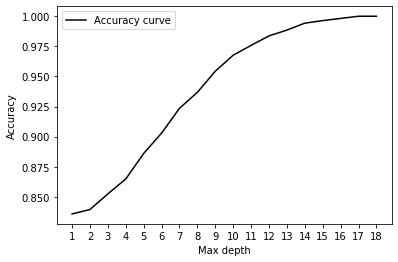

In [202]:
# show the accuracy in the train data
Accuracy_Score=[]
Level=[]

for i in range(1,19):
    Start_time = time.time()
    Dectree_model_train = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    #prediction for X_Train
    Y_Pred_train = Dectree_model_train.predict(X_train)
    #print(Y_Pred)
    # show the Accuracy of Y_train with Y_predaction
    Accuracy_Score.append(accuracy_score(Y_train, Y_Pred_train))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,Accuracy_Score,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()



Time to fit Model 0.030791282653808594


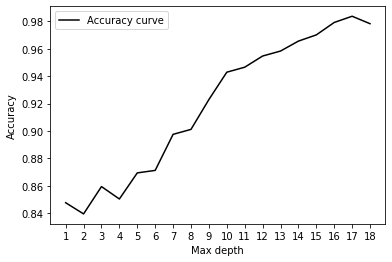

In [203]:
#show the accuracy in test data
accuracy=[]
Level=[]

for i in range(1,19):
    Start_time = time.time()
    Dectree_model = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    #prediction for X_Test
    Y_Pred = Dectree_model.predict(X_test)
    #print(Y_Pred)
    # show the Accuracy of Y_Test with Y_predaction
    accuracy.append(accuracy_score(Y_test, Y_Pred))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,accuracy,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()


In [204]:
# From the pervious graph we show the max depth and the accuracy so 
# now we can choose the suitable depth to get max accuracy 
for i in range(1,19):
    Start_time = time.time()
    Dectree_model = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    Y_Pred = Dectree_model.predict(X_test)
    print("Accuracy with each level = ",i,"is: ",accuracy_score(Y_test, Y_Pred))
Time=End_time-Start_time
print("Time Take to fit the model" , Time)


Accuracy with each level =  1 is:  0.8476881233000907
Accuracy with each level =  2 is:  0.8395285584768812
Accuracy with each level =  3 is:  0.8594741613780599
Accuracy with each level =  4 is:  0.8504079782411604
Accuracy with each level =  5 is:  0.8694469628286491
Accuracy with each level =  6 is:  0.8712601994560291
Accuracy with each level =  7 is:  0.9011786038077969
Accuracy with each level =  8 is:  0.900271985494107
Accuracy with each level =  9 is:  0.9220308250226654
Accuracy with each level =  10 is:  0.9419764279238441
Accuracy with each level =  11 is:  0.9446962828649139
Accuracy with each level =  12 is:  0.9528558476881233
Accuracy with each level =  13 is:  0.9646418857660924
Accuracy with each level =  14 is:  0.9664551223934723
Accuracy with each level =  15 is:  0.9755213055303718
Accuracy with each level =  16 is:  0.9755213055303718
Accuracy with each level =  17 is:  0.9755213055303718
Accuracy with each level =  18 is:  0.9791477787851315
Time Take to fit the

In [205]:
#improve the tuning parameters 
# The number of features to consider when looking for the best split:
l=['sqrt','log2','auto']
for feat in l:
    Dectree_model = DecisionTreeClassifier(max_depth = 19,max_features=feat).fit(X_train, Y_train)
    Y_Pred = Dectree_model.predict(X_test)
    print("Accuracy with max_features = ",feat,"is: ",accuracy_score(Y_test, Y_Pred))

Accuracy with max_features =  sqrt is:  0.9655485040797824
Accuracy with max_features =  log2 is:  0.9673617407071623
Accuracy with max_features =  auto is:  0.9764279238440616


In [206]:
Dectree_model = DecisionTreeClassifier(max_depth = 19,max_features='sqrt').fit(X_train, Y_train)
Train_Y_pred = Dectree_model.predict(X_train)
score=accuracy_score(Y_train,Train_Y_pred)
print(score)

1.0


In [207]:
Dectree_model = DecisionTreeClassifier(max_depth = 19,max_features='sqrt').fit(X_train, Y_train)
Y_Pred = Dectree_model.predict(X_test)
score=accuracy_score(Y_test,Y_Pred)
print(score)

0.971894832275612


In [208]:
Dectree_model = DecisionTreeClassifier(max_depth = 19,max_features='auto').fit(X_train, Y_train)
Y_Pred = Dectree_model.predict(X_test)
score=accuracy_score(Y_test,Y_Pred)
print(score)

0.9664551223934723
